### Polymer Profiles

This notebook contains a customizable plotting template for generating the core DISCO polymer profile plots, including:
* DISCO Fingerprint Plot ➡️ comparative interaction intimacies between polymer and protein  
* DISCO Buildup Curve Plot ➡️ relative measures of polymer proton proximity to the binding site
* DISCO Change Profile Plots ➡️ changes in buildup curve magnitude to track changes in polymer proton position

We apply a low to high convention in statistically testing for changes in polymer proton position with changes in polymer molecular weight. i.e. low molecular weight as the control, high molecular weight as the treatment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter 

Import the custom plotting and data manipulation functions used in this notebook:

In [2]:
from utils.wrangle_data import generate_disco_effect_mean_diff_df, generate_subset_sattime_df 
from utils.plotting import add_fingerprint_toax, add_buildup_toax, add_difference_plot_transposed, add_overlaid_buildup_toax_customlabels, add_difference_plot
from utils.plotting_helpers import assemble_peak_buildup_df

In [3]:
# Define a custom output directory for your figures
output_directory = "../paper/figurefiles"

### Plot Polymer Profile

Includes as a snapshot:
* Polymer structure diagram
* DISCO Interaction Fingerprint
* DISCO Buildup Curve Plot

In [4]:
# read the polymer data tables required for all styles of plotting
# high mW HPC
high_hpc_mean_all = pd.read_excel("../data/raw/stats_analysis_output_mean_all_HPC_370k_20uM.xlsx", index_col=[0, 1, 2, 3], header=[0, 1]).reset_index()
high_hpc_mean_bindingonly = pd.read_excel("../data/raw/stats_analysis_output_mean_HPC_370k_20uM.xlsx", index_col=[0, 1, 2, 3], header=[0, 1]).reset_index()
high_hpc_replicate_all = pd.read_excel("../data/raw/stats_analysis_output_replicate_all_HPC_370k_20uM.xlsx", index_col=[0], header=[0]).reset_index(drop=True)
high_hpc_replicate_bindingonly = pd.read_excel("../data/raw/stats_analysis_output_replicate_HPC_370k_20uM.xlsx", index_col=[0], header=[0]).reset_index(drop=True)

# low mW HPC
low_hpc_mean_all = pd.read_excel("../data/raw/stats_analysis_output_mean_all_HPC_80k_20uM.xlsx", index_col=[0, 1, 2, 3], header=[0, 1]).reset_index()
low_hpc_replicate_all = pd.read_excel("../data/raw/stats_analysis_output_replicate_all_HPC_80k_20uM.xlsx", index_col=[0], header=[0]).reset_index(drop=True)
low_hpc_replicate_bindingonly = pd.read_excel("../data/raw/stats_analysis_output_replicate_HPC_80k_20uM.xlsx", index_col=[0], header=[0]).reset_index(drop=True)

Next, design a custom plot axes configuration using the mosaic, and apply builtin functions to overlay polymer profiles as desired.

See [this tutorial](https://matplotlib.org/stable/tutorials/provisional/mosaic.html) on matplotlib mosaic plots for a helpful introduction. 

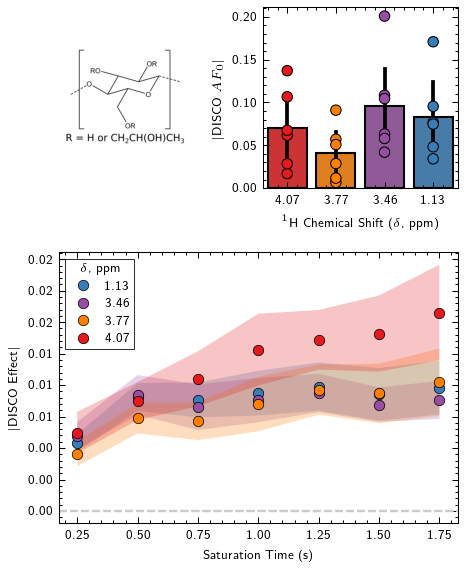

In [5]:
mosaic = """
    AB
    CC
    """

gs_kw = dict(width_ratios=[1, 1.5], height_ratios=[1, 1.5])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(3.3, 4),
                              constrained_layout=False, dpi=150)

hpc_structure = plt.imread("../data/external/hpc_repeatunit.png", format="png")

# Polymer Structure Axis
axd['A'].imshow(hpc_structure)
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)

# Binding fingerprint plot
add_fingerprint_toax(high_hpc_replicate_bindingonly, axd['B'])
axd['B'].set_ylabel("$$|\mbox{DISCO $AF_0$}|$$", fontsize = 6)
axd['B'].set_xlabel("$^1$H Chemical Shift ($\delta$, ppm)", fontsize = 6)
axd['B'].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axd['B'].tick_params(axis='x', labelsize=6)
axd['B'].tick_params(axis='y', labelsize=6)

# Build up curve plot
add_buildup_toax(high_hpc_mean_bindingonly, axd['C'])
axd['C'].set_ylabel("$$|\mbox{DISCO Effect}|$$", fontsize = 6)
axd['C'].set_xlabel("Saturation Time (s)", fontsize = 6)
axd['C'].axhline(y=0.0, color="0.8", linestyle='dashed')
axd['C'].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axd['C'].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axd['C'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['C'].tick_params(axis='x', labelsize = 6)
axd['C'].tick_params(axis='y', labelsize = 6)

# format legend
props = dict(facecolor='white', linewidth=0.5)
legC = axd['C'].legend(loc='upper left', title="$\delta$, ppm", frameon=True, fontsize=6, fancybox = False)
legC.get_frame().set_edgecolor('k')
legC.get_title().set_fontsize('6')
legC.get_frame().set_linewidth(0.5)

# save as png, svg
output_filename2 = f"{output_directory}/hpc.png"
output_filename = f"{output_directory}/hpc.svg"
plt.tight_layout()
fig.patch.set_facecolor('white')
fig.savefig(output_filename, dpi=500, transparent=False)
fig.savefig(output_filename2, dpi=500, transparent=False)


### HPC Change Profile Snapshot

Next, we examine the change profile between two molecular weights of HPC. Specifically, the change in HPC proton positioned incurred by increasing molecular weight from 80kDa to 370kDa.

The code below:

* preprocesses raw data tables to ready them for difference profile plotting 
* conducts statistical testing, and prints a summary report of change significance (p < 0.05)
* subsets data to NMR saturation time = 0.25s for the plot

The difference profile plot is created using the "subset_sattime_df," which contains only the mean difference in disco effect data computed for the desired saturation time slice. We use t=0.25s as the most representative saturation time, as it is closest to the instantaneous measure.

In [6]:
print("HPC Results:")
hpc_effect_size_df = generate_disco_effect_mean_diff_df(low_hpc_replicate_all, high_hpc_replicate_all)
hpc_subset_sattime_df = generate_subset_sattime_df(hpc_effect_size_df, 0.25)

HPC Results:
Sig Point is: 0.25, 4.5814, p = 0.002852946493998779, n = 6
Sig Point is: 0.25, 4.06765, p = 0.022112708130022727, n = 6
Sig Point is: 0.5, 4.5814, p = 0.04792935070570668, n = 6
Sig Point is: 1.0, 4.06765, p = 0.02587405440747963, n = 6
Sig Point is: 1.5, 4.5814, p = 0.013839648335416047, n = 6
Sig Point is: 1.5, 4.06765, p = 0.030839653145183932, n = 6
Sig Point is: 1.75, 4.5814, p = 0.008178181853274912, n = 6


Now, assemble custom mosaic for plotting HPC's difference profile snapshot at t=0.25s.

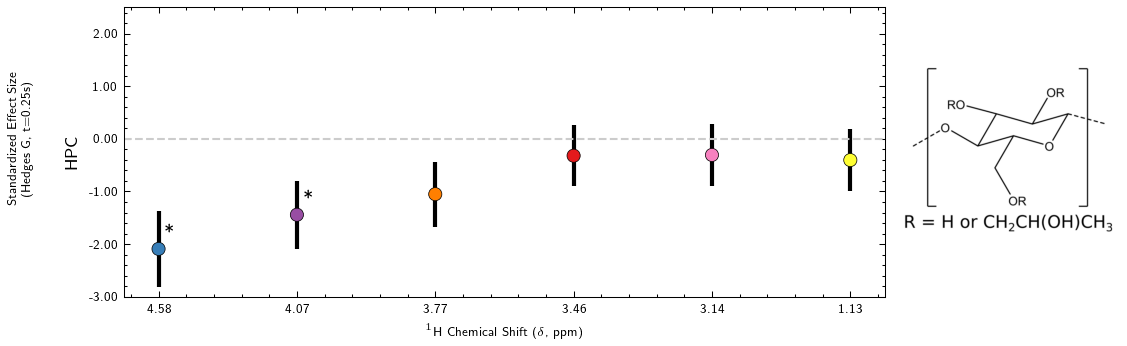

In [7]:
mosaic = '''
A.B
'''

ppm_colors = ['#377eb8', '#984ea3', '#ff7f00', '#e41a1c', '#f781bf',
              '#ffff33', '#4daf4a', '#a65628', '#999999']

gs_kw = dict(width_ratios=[1,0.05,0.3], height_ratios=[2.5])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 2),
                              constrained_layout=False, dpi=150)

# read image data
hpc_structure = plt.imread("../data/external/hpc_repeatunit.png", format="png")

# polymer structure - HPC
axd['B'].imshow(hpc_structure)
axd['B'].axis('off')
axd['B'].xaxis.set_visible(False)
axd['B'].yaxis.set_visible(False)

# difference fingerprint - HPC
add_difference_plot_transposed(df=hpc_subset_sattime_df, ax=axd['A'], dy=0.3, **{"custom_colors": ppm_colors})
axd["A"].set_ylabel("HPC", fontsize=8)
axd["A"].set_ylim(-3, 2.5)  
axd['A'].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axd['A'].set_xlabel("$^1$H Chemical Shift ($\delta$, ppm)", fontsize=6)
axd['A'].tick_params(axis='x', labelsize=6)
axd['A'].tick_params(axis='y', labelsize=6)


# triple ax label
t = axd['A'].text(0, 0, "Standardized Effect Size \n(Hedges G, t=0.25s)", ha="center", va="center", rotation=90, fontsize =6)

# save as png, svg
output_filename = f"{output_directory}/hpc_change_fig.svg"
output_filename2 = f"{output_directory}/hpc_change_fig.png"
fig.patch.set_facecolor('white')
plt.tight_layout(pad = -0.75)
fig.savefig(output_filename, dpi=500, transparent=False)
fig.savefig(output_filename2, dpi=500, transparent=False)


### HPC Change Profile with Buildup Curves

For extra context on the difference profile, we can view the snapshot alongside the full peak-wise buildup curve comparisons for each proton. 

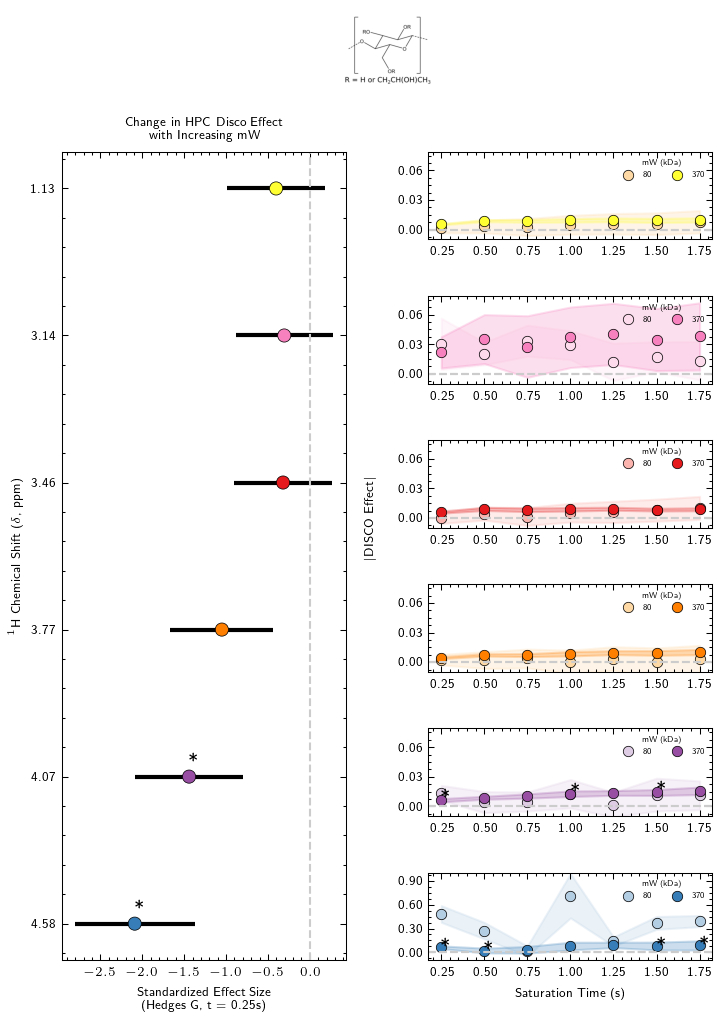

In [8]:
# grab each protons data
ppi_1_low = assemble_peak_buildup_df(low_hpc_replicate_all, 1)
ppi_2_low = assemble_peak_buildup_df(low_hpc_replicate_all, 2)
ppi_3_low = assemble_peak_buildup_df(low_hpc_replicate_all, 3)
ppi_4_low = assemble_peak_buildup_df(low_hpc_replicate_all, 4)
ppi_5_low = assemble_peak_buildup_df(low_hpc_replicate_all, 5)
ppi_6_low = assemble_peak_buildup_df(low_hpc_replicate_all, 6)

ppi_1_high = assemble_peak_buildup_df(high_hpc_replicate_all, 1)
ppi_2_high = assemble_peak_buildup_df(high_hpc_replicate_all, 2)
ppi_3_high = assemble_peak_buildup_df(high_hpc_replicate_all, 3)
ppi_4_high = assemble_peak_buildup_df(high_hpc_replicate_all, 4)
ppi_5_high = assemble_peak_buildup_df(high_hpc_replicate_all, 5)
ppi_6_high = assemble_peak_buildup_df(high_hpc_replicate_all, 6)

mosaic = """
    AA
    BF
    BG
    BH
    BI
    BJ
    BK
"""


gs_kw = dict(width_ratios=[1, 1],
             height_ratios=[1, 1, 1, 1, 1, 1, 1])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(5, 7),
                              constrained_layout=False, dpi=150)

# always ensure low to high order for correct labelling
hpc_names = ["80", "370"]
ppm_colors = ['#377eb8', '#984ea3', '#ff7f00', '#e41a1c', '#f781bf',
              '#ffff33', '#4daf4a', '#a65628', '#999999']

# low vs high per ppm
buildup_colors9 = ['#f2f2f2',  '#999999']
buildup_colors8 = ['#e5d8bd',  '#a65628']
buildup_colors7 = ['#ccebc5', '#4daf4a']
buildup_colors6 = ['#fed9a6', '#ffff33']
buildup_colors5 = ['#fddaec',  '#f781bf']
buildup_colors4 = ['#fbb4ae',  '#e41a1c']
buildup_colors3 = ['#fed9a6', '#ff7f00']
buildup_colors2 = ["#decbe4", "#984ea3"]
buildup_colors1 = ['#b3cde3', '#377eb8']

kwargs = {"labels": hpc_names,
          "dx": 0.001,
          "dy": 0.0020,
          "change_significance": hpc_effect_size_df,
          "annot_color": "#000000"}

# Structure Axis
axd['A'].imshow(hpc_structure)
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)
axd['A'].set_xlabel("Hydroxypropyl Cellulose")


# add change fingerprint
add_difference_plot(df=hpc_subset_sattime_df,
                  ax=axd['B'], dy=0.1, **{"custom_colors": ppm_colors})
axd["B"].set_title("Change in HPC Disco Effect\nwith Increasing mW", fontsize=6)
axd["B"].set_xlabel("Standardized Effect Size \n(Hedges G, t = 0.25s)", fontsize=6)
axd["B"].set_ylabel("$^1$H Chemical Shift ($\delta$, ppm)", fontsize = 6)
axd['B'].tick_params(axis='x', labelsize=6)
axd['B'].tick_params(axis='y', labelsize=6)

# add buildup curves for each peak
df_list = [ppi_1_low, ppi_1_high]
add_overlaid_buildup_toax_customlabels(df_list, axd['K'], **kwargs, **{"custom_colors": buildup_colors1})
axd['K'].set_ylim((-0.1, 1.0))
axd['K'].yaxis.set_ticks(np.arange(0.0, 1.0, 0.3))
axd['K'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['K'].set_xlabel("Saturation Time (s)", fontsize = 6)
axd['K'].tick_params(axis='x', labelsize=6)
axd['K'].tick_params(axis='y', labelsize=6)

df_list = [ppi_2_low, ppi_2_high]
add_overlaid_buildup_toax_customlabels(df_list, axd['J'], **kwargs, **{"custom_colors": buildup_colors2})
axd['J'].set_ylim((-0.01, 0.079))
axd['J'].yaxis.set_ticks(np.arange(0.0, 0.075, 0.03))
axd['J'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['J'].tick_params(axis='x', labelsize=6)
axd['J'].tick_params(axis='y', labelsize=6)

df_list = [ppi_3_low, ppi_3_high]
add_overlaid_buildup_toax_customlabels(df_list, axd['I'], **kwargs, **{"custom_colors": buildup_colors3})
axd['I'].set_ylim((-0.01, 0.079))
axd['I'].yaxis.set_ticks(np.arange(0.0, 0.075, 0.03))
axd['I'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['I'].tick_params(axis='x', labelsize=6)
axd['I'].tick_params(axis='y', labelsize=6)

df_list = [ppi_4_low, ppi_4_high]
add_overlaid_buildup_toax_customlabels(df_list, axd['H'], **kwargs, **{"custom_colors": buildup_colors4})
axd['H'].set_ylim((-0.01, 0.079))
axd['H'].yaxis.set_ticks(np.arange(0.0, 0.075, 0.03))
axd['H'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['H'].tick_params(axis='x', labelsize=6)
axd['H'].tick_params(axis='y', labelsize=6)

df_list = [ppi_5_low, ppi_5_high]
add_overlaid_buildup_toax_customlabels(df_list, axd['G'], **kwargs, **{"custom_colors": buildup_colors5})
axd['G'].set_ylim((-0.01, 0.079))
axd['G'].yaxis.set_ticks(np.arange(0.0, 0.075, 0.03))
axd['G'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['G'].tick_params(axis='x', labelsize=6)
axd['G'].tick_params(axis='y', labelsize=6)

df_list = [ppi_6_low, ppi_6_high]
add_overlaid_buildup_toax_customlabels(df_list, axd['F'], **kwargs, **{"custom_colors": buildup_colors6})
axd['F'].set_ylim((-0.01, 0.079))
axd['F'].yaxis.set_ticks(np.arange(0.0, 0.075, 0.03))
axd['F'].xaxis.set_ticks(np.arange(0.25, 2.0, 0.25))
axd['F'].tick_params(axis='x', labelsize=6)
axd['F'].tick_params(axis='y', labelsize=6)

# format legend(s)
legends = [ "F", "G", "H", "I", "J", "K"]
props = dict(boxstyle='round', facecolor='white', linewidth=1.0)
for letter in legends:
    leg = axd[f'{letter}'].legend(
        loc='upper right', title="mW (kDa)", frameon=False, fontsize=4, ncol=2)
    leg.get_frame().set_edgecolor('k')
    leg.get_title().set_fontsize('4')

    # set decimal places in plot
    axd[f'{letter}'].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axd[f'{letter}'].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# buildup curve labels
t = axd['H'].text(-0.20, 0.0, "$$|\mbox{DISCO Effect}|$$", ha="left", va="center", rotation=90, fontsize =6)
plt.tight_layout()

# save as svg
output_filename = f"{output_directory}/hpc_peakwisebuildups.svg"
fig.patch.set_facecolor('white')
fig.savefig(output_filename, dpi=500, transparent=False)

# save as png
output_filename2 = f"{output_directory}/hpc_peakwisebuildups.png"
fig.patch.set_facecolor('white')
fig.savefig(output_filename2, dpi=500, transparent=False)
